In [1]:
# Import Basics Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *

In [2]:
# Read in training data from CSV
df_train = pd.read_csv('./Twitter/twitter_training.csv')
df_train.columns =['TweetId', 'Entity', 'Sentiment', 'Tweet']
df_train

,TweetId,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [3]:
# Downsample the training set to ~4,995 samples
percentage = 0.067
df_train_downsampled = df_train.sample(frac=percentage,random_state=0)
df_train_downsampled

,TweetId,Entity,Sentiment,Tweet
28696,537,ApexLegends,Neutral,"is, why would it fucking matter if two games h..."
51606,10459,RedDeadRedemption(RDR),Neutral,This looks like the opening scene of Red Dead ...
19463,12533,WorldOfCraft,Neutral,I always get sad in the troll starter area whe...
26251,907,AssassinsCreed,Positive,Brotherhood Clothing
55871,2391,CallOfDuty,Negative,@CallofDuty @CallofDutyUK firstly you need to ...
...,...,...,...,...
18818,12425,WorldOfCraft,Irrelevant,Remember how he pushed a remote up his ass bc ...
68937,3806,Cyberpunk2077,Positive,Oh Their chairs sure are 5 / 8 7 perfect score...
41134,1459,Battlefield,Positive,4 favorite games from all time?.. Max the 2. F...
35009,8015,Microsoft,Neutral,@Forbes features our Data Quadrant and Emotion...


In [4]:
# Read in testing data from CSV
df_test = pd.read_csv('./Twitter/twitter_validation.csv')
df_test.columns =['TweetId', 'Entity', 'Sentiment', 'Tweet']
df_test

,TweetId,Entity,Sentiment,Tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [5]:
# Convert sentiment values to numbers (i.e. positive is 1, negative is 0, and neutral is 2, irrelevant is 2)
df_train_downsampled["Sentiment"].replace({"Positive": 1, "Negative": 0, "Neutral":2, "Irrelevant":2}, inplace=True)
df_test["Sentiment"].replace({"Positive": 1, "Negative": 0, "Neutral":2, "Irrelevant":2}, inplace=True)
df_train_downsampled

,TweetId,Entity,Sentiment,Tweet
28696,537,ApexLegends,2,"is, why would it fucking matter if two games h..."
51606,10459,RedDeadRedemption(RDR),2,This looks like the opening scene of Red Dead ...
19463,12533,WorldOfCraft,2,I always get sad in the troll starter area whe...
26251,907,AssassinsCreed,1,Brotherhood Clothing
55871,2391,CallOfDuty,0,@CallofDuty @CallofDutyUK firstly you need to ...
...,...,...,...,...
18818,12425,WorldOfCraft,2,Remember how he pushed a remote up his ass bc ...
68937,3806,Cyberpunk2077,1,Oh Their chairs sure are 5 / 8 7 perfect score...
41134,1459,Battlefield,1,4 favorite games from all time?.. Max the 2. F...
35009,8015,Microsoft,2,@Forbes features our Data Quadrant and Emotion...


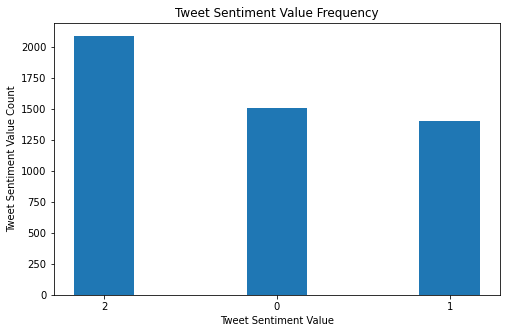

In [6]:
# Visual of Training Samples' Outcomes - Even Distribution of Outcomes
sent_count = df_train_downsampled['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)

plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())
plt.xlabel('Tweet Sentiment Value')
plt.ylabel('Tweet Sentiment Value Count')
plt.title('Tweet Sentiment Value Frequency')

plt.show()

In [7]:
# Eliminate Title Feature - Train
TrainXdf = df_train_downsampled['Tweet']
TrainYdf = df_train_downsampled['Sentiment']
[TrainXdf, TrainYdf]

[28696    is, why would it fucking matter if two games h...
 51606    This looks like the opening scene of Red Dead ...
 19463    I always get sad in the troll starter area whe...
 26251                                 Brotherhood Clothing
 55871    @CallofDuty @CallofDutyUK firstly you need to ...
                                ...                        
 18818    Remember how he pushed a remote up his ass bc ...
 68937    Oh Their chairs sure are 5 / 8 7 perfect score...
 41134    4 favorite games from all time?.. Max the 2. F...
 35009    @Forbes features our Data Quadrant and Emotion...
 6196                                                   are
 Name: Tweet, Length: 5004, dtype: object,
 28696    2
 51606    2
 19463    2
 26251    1
 55871    0
         ..
 18818    2
 68937    1
 41134    1
 35009    2
 6196     0
 Name: Sentiment, Length: 5004, dtype: int64]

In [8]:
# Eliminate Title Feature - Test
TestXdf = df_test['Tweet']
TestYdf = df_test['Sentiment']
[TestXdf, TestYdf]

[0      BBC News - Amazon boss Jeff Bezos rejects clai...
 1      @Microsoft Why do I pay for WORD when it funct...
 2      CSGO matchmaking is so full of closet hacking,...
 3      Now the President is slapping Americans in the...
 4      Hi @EAHelp I’ve had Madeleine McCann in my cel...
                              ...                        
 994    ⭐️ Toronto is the arts and culture capital of ...
 995    tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
 996    Today sucked so it’s time to drink wine n play...
 997    Bought a fraction of Microsoft today. Small wins.
 998    Johnson & Johnson to stop selling talc baby po...
 Name: Tweet, Length: 999, dtype: object,
 0      2
 1      0
 2      0
 3      2
 4      0
       ..
 994    2
 995    2
 996    1
 997    1
 998    2
 Name: Sentiment, Length: 999, dtype: int64]

In [9]:
if ( not TrainXdf.isnull().values.any() and not TrainYdf.isnull().values.any() ):
    print("Training set has no NULL values.")
else:
    if ( TrainXdf.isnull().values.any() ):
        null_tweets = df_train_downsampled[df_train_downsampled['Tweet'].isnull()].index.tolist()
        print("Null Tweets exist in Training Set. Dropping", len(null_tweets), "rows")
        df_train_downsampled.dropna(subset = ["Tweet"], inplace=True)
        TrainXdf = df_train_downsampled["Tweet"]
        TrainYdf = df_train_downsampled["Sentiment"]
        print("Null values Exist In X,Y Training Set:", TrainXdf.isnull().values.any(), TrainYdf.isnull().values.any())
    if ( TrainYdf.isnull().values.any() ):
        null_sent = df_train_downsampled[df_train_downsampled['Sentiment'].isnull()].index.tolist()
        print("Null Sentiments exist in Training Set. Dropping", len(null_sent), "rows")
        df_train_downsampled.dropna(subset = ["Sentiment"], inplace=True)
        TrainXdf = df_train_downsampled["Tweet"]
        TrainYdf = df_train_downsampled["Sentiment"]
        print("Null values Exist:", TrainXdf.isnull().values.any(), TrainYdf.isnull().values.any())
if ( not TestXdf.isnull().values.any() and not TestYdf.isnull().values.any() ):
    print("Testing set has no NULL values.")

Null Tweets exist in Training Set. Dropping 36 rows
Null values Exist In X,Y Training Set: False False
Testing set has no NULL values.


In [10]:
# "One-Hot Encoding" Function that converts the Tweets to Numerical Arrays
def oneHotEnc(Tweet):
    token_item = []

    for letter in Tweet:
        if ord(letter) >= ord('a') and ord(letter) <= ord('z'):
            token_item.append(ord(letter) - ord('a'))
        elif letter == ' ':
            token_item.append(-1)
        else:
            pass

    return token_item

# Function that Pre-Processes the Tweets
def PreProcess(tweets, method):
    pre_procc_tweets = []

    # Storing all punctuations using RE library like !;,"% etc
    re_puncs = re.compile('[%s]' % re.escape(string.punctuation))

    # Storing all stop words like a, an, the, when, there, this etc
    stop_word  = set(stopwords.words('english'))

    # Lemmatizing object
    lem = WordNetLemmatizer()

    # Using Porter Stemmer
    p_stem = PorterStemmer()

    for tweet in tweets:
        # Get words in tweet
        words = word_tokenize(str(tweet))

        # Converting all characters to lower case
        words_lower = [w.lower() for w in words]

        # Remove all punctuation
        words_lower_no_punc = [re_puncs.sub('', w) for w in words_lower]

        # Keep only alpha words
        words_lower_alpha = [i for i in words_lower_no_punc if i.isalpha()]

        # Removing all stop words
        words_lower_alpha_nostop = [w for w in words_lower_alpha if w not in stop_word]

        # Doing Lemmatizing of words
        words_lower_alpha_nostop_lemma = [lem.lemmatize(w) for w in words_lower_alpha_nostop]

        # Stemming process
        words_lower_alpha_nostop_lemma_stem = [p_stem.stem(w) for w in words_lower_alpha_nostop_lemma]

        # Convert back to string and (possibly) one-hot encode tweet
        pre_procc_str = ' '.join(words_lower_alpha_nostop_lemma_stem)
        if (method==1):
            procc_tweet = oneHotEnc(pre_procc_str)
        else:
            procc_tweet=pre_procc_str
        pre_procc_tweets.append(procc_tweet)
        
    return pre_procc_tweets

# Encoding method (1 for NGRAM, 0 for TOKENIZATION)
method = 0

# Max Number of features for Tokenization
max_features = 700

# Pre-Process the Tweets and Get Finalized Training and Testing Sets
TrainXdf = PreProcess(TrainXdf,method)
TestXdf = PreProcess(TestXdf,method)

if (method ==0):
    cnt = CountVectorizer(analyzer="word", max_features=max_features)
    TrainXdf = cnt.fit_transform(TrainXdf).toarray()
    TestXdf=cnt.transform(TestXdf).toarray()

TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)

print(TrainXdf.shape)
print(TestXdf.shape)

(4968, 700)
(999, 700)


In [11]:
# Item Memory Generation Function, NGRAM
def itemMemGen_NGRAM(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    return dictMem
# Item Memory Generation Function, TOKENIZATION
def itemMemGen_TOKEN(features, dim=10000):
    dictMem = np.random.randint(2, size=(features, dim), dtype='int32')
    return dictMem

# Hyperparamaters
HV_dim = 10000
num_supported_chars = 27

# Item Memory Generation
if (method ==1):
    itemMem = itemMemGen_NGRAM(dim=HV_dim, num_char=num_supported_chars)
else:
    itemMem = itemMemGen_TOKEN(features=len(TrainXdf[0]), dim=HV_dim)

In [12]:
# Function for Encoding a Tweet into a HV
def encode(tweet, itemMem, method, HV_dim=10000, n_gram_len=3):
    if (method==1):
        tweet_HV = np.zeros(HV_dim, dtype='int32')

        for ngram_start in range(0, len(tweet)-n_gram_len, 3):
            roll_value=n_gram_len
            for j in range(n_gram_len):
                letterHV = itemMem[tweet[ngram_start + j]]

                if (j==0):
                    product = letterHV
                elif (j==n_gram_len-1):
                    product = product * np.roll(letterHV, roll_value)
                    tweet_HV = np.add(tweet_HV, product)
                else:
                    product = product * np.roll(letterHV, roll_value)
                    
                roll_value = roll_value - 1

        HV_avg = np.average(tweet_HV)
        tweet_HV[tweet_HV > HV_avg] = 1
        tweet_HV[tweet_HV < HV_avg] = -1
        tweet_HV[tweet_HV == HV_avg] = 0
        return tweet_HV
    else:
        return tweet.dot(itemMem)

# HDC Training Function Creates Associative Memory
def train(X, Y, itemMem, HV_dim, sent_count, n_gram_len, method):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    tweet_idx = 0
    
    for tweet in X:
        tweet_HV = encode(tweet.reshape(1, len(tweet)), itemMem, method, HV_dim, n_gram_len)
        if (tweet_idx==0):
            print(tweet_HV.shape)
        assocMem[Y[tweet_idx]] = np.add(assocMem[Y[tweet_idx]], tweet_HV)
        tweet_idx += 1

    return assocMem

n_gram_len = 3
assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), n_gram_len, method)
assocMem

(1, 10000)


array([[5185, 5611, 5405, ..., 5448, 5885, 5768],
       [4182, 4600, 4120, ..., 4385, 4688, 5015],
       [6446, 7152, 6745, ..., 6920, 7237, 7353]])

In [13]:
# Function Compares Input HV to Class HVs and Returns the Predicted Class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

# Function Tests the Model and Return Accuracy of Model
def test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method):
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, method, HV_dim, n_gram_len))
        if (TestYdf[index] == prediction):
            correct_count += 1
            
    accuracy = (correct_count / len(TestYdf)) * 100
    return accuracy

# One-Shot Training Results
one_shot_accuracy=test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
print("One Shot Accuracy: ", one_shot_accuracy)

One Shot Accuracy:  57.75775775775776


In [14]:
def retrain(X, Y, itemMem, assocMem, HV_dim, n_gram_len, method, alpha):
    tweet_index = 0
    print("start")
    for tweet in X:
        tweet_HV = encode(tweet, itemMem, method, HV_dim, n_gram_len)
        prediction = get_prediction(assocMem, tweet_HV)
        if prediction != Y[tweet_index]:
            assocMem[Y[tweet_index]] = np.add(assocMem[Y[tweet_index]], alpha * tweet_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * tweet_HV)
        tweet_index += 1
        if(tweet_index%10000 == 0):
            print("still going", tweet_index)
    return assocMem

# Re-Train Model
num_epochs = 20
print('-------- Retraining Model: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, HV_dim, n_gram_len, method, alpha = num_epochs - epoch)
    acc = test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
    print('Epoch ', (epoch+1), ': ', acc)

-------- Retraining Model:  20  Epochs --------
start
Epoch  1 :  47.047047047047045
start
Epoch  2 :  49.849849849849846
start
